In [1]:
from google.colab import drive

# This will prompt you to authenticate and grant access to your Drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# in sample df
df = pd.read_csv("/content/drive/MyDrive/My Projects/FX/insample.csv")

In [4]:
def feature_engineering_new(df):
  df = df.copy()

  # os df does not have Traded column
  if 'Traded' in df.columns:
    df['Traded'] = df['Traded'].map({'MISSED': 0, 'DONE': 1})


  df['signed_distance'] = df.apply(
      lambda x: (x['QuotedPrice'] - x['MidPrice']) / x['MidPrice'] * 10000 if x['Side'] == 'ASK'
      else (x['MidPrice'] - x['QuotedPrice']) / x['MidPrice'] * 10000,
      axis=1
  )

  df['HighCompetition'] = (df['Competitors'] > 4).astype(int)

  if 'nextMidPrice' in df.columns:

    df['signed_distance_next'] = df.apply(
        lambda x: (x['QuotedPrice'] - x['nextMidPrice']) / x['nextMidPrice'] * 10000 if x['Side'] == 'ASK'
        else (x['nextMidPrice'] - x['QuotedPrice']) / x['nextMidPrice'] * 10000,
        axis=1
    )

  # Encode categorical columns
  df = pd.get_dummies(df, columns=['Side', 'Counterparty', 'Bond'], drop_first=True)

  df = df.drop(columns=['Time', 'MidPrice', 'nextMidPrice'])

  return df

In [6]:
df_featured = feature_engineering_new(df)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best Parameters for Highest Accuracy:
{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 1.0}
Highest Accuracy on Validation Set: 0.8300
Log Loss of Best Accuracy Model on Test Set: 0.4426


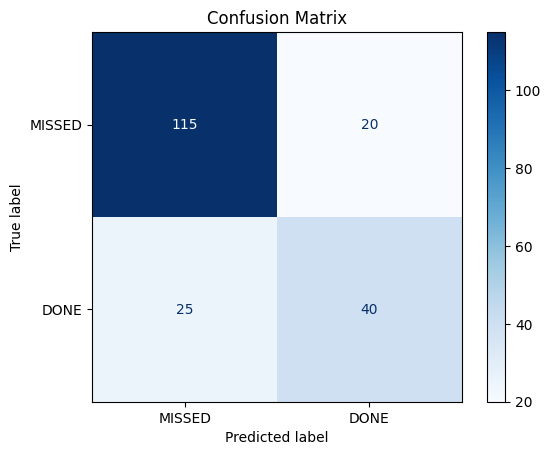

In [9]:
# Feature matrix and target vector
X = df_featured.drop(columns=['Traded'])
y = df_featured['Traded']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid search for highest accuracy
grid_search_acc = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',  # Use accuracy for grid search
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search model for accuracy
grid_search_acc.fit(X_train, y_train)

# Best parameters for highest accuracy
best_params_accuracy = grid_search_acc.best_params_
highest_accuracy = grid_search_acc.best_score_

# Evaluate the best model on test data for log loss
best_xgb_acc = grid_search_acc.best_estimator_
y_pred_prob_acc = best_xgb_acc.predict_proba(X_test)
log_loss_acc_model = log_loss(y_test, y_pred_prob_acc)
y_pred = best_xgb_acc.predict(X_test)

# Output the results
print("\nBest Parameters for Highest Accuracy:")
print(best_params_accuracy)
print(f"Highest Accuracy on Validation Set: {highest_accuracy:.4f}")
print(f"Log Loss of Best Accuracy Model on Test Set: {log_loss_acc_model:.4f}")
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["MISSED", "DONE"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()